# Imports

In [2]:
dark_mode = False

# Importing necessary libraries for neural networks
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import (make_scorer, accuracy_score, precision_score, recall_score, 
                            f1_score, ConfusionMatrixDisplay, confusion_matrix, 
                            matthews_corrcoef, classification_report, roc_auc_score)
import pickle
import joblib
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from astropy.coordinates import SkyCoord
from astropy import units as u
import optuna
from sklearn.model_selection import cross_val_score
import os
from re import M

# Display settings
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)

# Resetar matplotlib para tema padrão (claro)
plt.style.use('default')
plt.rcParams.update(plt.rcParamsDefault)

# Random seed for reproducibility
SEED = 333
np.random.seed(SEED)

import matplotlib
# Plot visual settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

thesis_settings = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "font.size": 11,
    "axes.labelsize": "medium",
    "axes.titlesize": "medium",
    "figure.labelsize": "medium",
    "figure.titlesize": "medium",
    # Make the legend/label fonts a little smaller
    "legend.fontsize": "small",
    "legend.title_fontsize": "small",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    # Enable axis grids
    "axes.grid": True,
    "grid.alpha": 0.5,
    # Constrained layout
    "figure.constrained_layout.use": True, # When this in True, do not use tight_layout
    "savefig.transparent": False,
    'savefig.bbox': 'tight',
}
plt.rcParams.update(thesis_settings)

if dark_mode == True:
    #If the plots are to be used in a dark presentation
    plt.style.use('default') 
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.style.use("dark_background")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=default_colors)
    plt.rcParams.update(thesis_settings)
    plt.rcParams.update({
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "legend.facecolor": "#1a1a1a",
        "legend.edgecolor": "white",
        "text.color": 'white',
        "axes.facecolor": "#070207",
        "savefig.facecolor": (0.0, 0.0, 0.0, 0.0)
        })
    bbox = dict(facecolor='#1a1a1a', edgecolor='white', lw=0.5, boxstyle='round,pad=0.2')
    details_colour = 'white'

saveformat = 'pdf' # 'svg'


if dark_mode == True:
    #If the plots are to be used in a dark presentation
    plt.style.use('default') 
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.style.use("dark_background")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=default_colors)
    plt.rcParams.update(thesis_settings)
    plt.rcParams.update({
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "legend.facecolor": "#1a1a1a",
        "legend.edgecolor": "white",
        "text.color": 'white',
        "axes.facecolor": "#070207",
        "savefig.facecolor": (0.0, 0.0, 0.0, 0.0)
        })
    
    # Configurações específicas para seaborn com tema escuro
    import seaborn as sns
    sns.set_theme(style="darkgrid", rc={
        'axes.facecolor': '#070207',
        'figure.facecolor': '#070207',
        'grid.color': 'white',
        'grid.alpha': 0.2,
        'text.color': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white'
    })
    
    bbox = dict(facecolor='#1a1a1a', edgecolor='white', lw=0.5, boxstyle='round,pad=0.2')
    details_colour = 'white'

c:\Users\Carlos\Desktop\atividade_2\ML_project_ifusp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
path_train_main = "../data/photoz_main.parquet"

train_main = pd.read_parquet(path_train_main, engine='pyarrow')

In [4]:
BROADBANDS = ['u', 'g', 'r', 'i', 'z']

# Filtros de banda estreita (narrowband)
NARROWBANDS = ['j0378', 'j0395', 'j0410', 'j0430', 'j0515', 'j0660', 'j0861']


BASIC_COLS = ['id', 'ra', 'dec', 'z', 'e_z']

mags_auto = [f'mag_auto_{mag}' for mag in BROADBANDS + NARROWBANDS]
err_mags_auto = [f'err_mag_auto_{mag}' for mag in BROADBANDS + NARROWBANDS]

# Ajustando dados #

O ajuste dos dados será feito por meio de uma análise exploratório do conjunto de dados train_main. O conjuto apresenta 28 features e 3108756 linhas, para filtrar dados que não contribuem para treinamento será feita a remoção de magnitudes maiores que 21.

In [ ]:
print(f"Shape inicial dos dados: {train_main.shape}")
print(f"\nPrimeiras linhas:")
train_main.head()

Shape inicial dos dados: (3108756, 29)

Primeiras linhas:


,id,ra,dec,z,e_z,mag_auto_u,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_j0378,mag_auto_j0395,mag_auto_j0410,mag_auto_j0430,mag_auto_j0515,mag_auto_j0660,mag_auto_j0861,err_mag_auto_u,err_mag_auto_g,err_mag_auto_r,err_mag_auto_i,err_mag_auto_z,err_mag_auto_j0378,err_mag_auto_j0395,err_mag_auto_j0410,err_mag_auto_j0430,err_mag_auto_j0515,err_mag_auto_j0660,err_mag_auto_j0861
0,i06n18s18001A7,175.943517,-23.587699,1.04864,NaN,20.277293,20.120172,19.762041,19.694902,19.722958,20.127302,20.242325,20.261901,20.532771,20.059221,19.672898,20.111174,0.070561,0.056693,0.041788,0.048521,0.085553,0.082318,0.140760,0.143022,0.174505,0.104951,0.043581,0.145700
1,i06n18s18001MH,175.555797,-23.578416,0.72373,NaN,21.818986,20.465810,20.533571,20.198797,19.970450,22.261784,21.436583,20.312107,20.475960,20.437926,20.908488,20.113799,0.435182,0.118789,0.128553,0.119463,0.171816,0.843198,0.650272,0.233774,0.258002,0.231810,0.203063,0.233605
2,i06n18s18001TE,175.047986,-23.572383,1.11743,NaN,19.591906,19.730809,19.397317,19.281098,19.129115,19.839671,19.883803,19.398864,19.596744,19.600159,19.368172,19.420694,0.072505,0.075176,0.056415,0.064076,0.096469,0.117101,0.196281,0.127555,0.144458,0.131909,0.061533,0.150597
3,i06n18s18001VX,174.844348,-23.568633,0.88875,NaN,20.826173,20.935200,20.492187,20.417405,20.849883,20.547972,21.285364,21.190351,20.261062,20.720682,20.402840,20.734328,0.129348,0.132739,0.090529,0.107546,0.271939,0.139968,0.434599,0.390660,0.159157,0.214576,0.093533,0.291475
4,i06n18s180020D,175.838464,-23.567624,2.65685,NaN,21.117917,20.219272,19.883008,19.954022,19.816639,20.375182,21.299686,20.737359,20.299591,19.997370,20.016784,20.443599,0.216408,0.092696,0.069273,0.092420,0.144722,0.146356,0.545217,0.330855,0.213931,0.149465,0.087521,0.306690


Shape inicial dos dados: (3108756, 29)

Primeiras linhas:


,id,ra,dec,z,e_z,mag_auto_u,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_j0378,mag_auto_j0395,mag_auto_j0410,mag_auto_j0430,mag_auto_j0515,mag_auto_j0660,mag_auto_j0861,err_mag_auto_u,err_mag_auto_g,err_mag_auto_r,err_mag_auto_i,err_mag_auto_z,err_mag_auto_j0378,err_mag_auto_j0395,err_mag_auto_j0410,err_mag_auto_j0430,err_mag_auto_j0515,err_mag_auto_j0660,err_mag_auto_j0861
0,i06n18s18001A7,175.943517,-23.587699,1.04864,NaN,20.277293,20.120172,19.762041,19.694902,19.722958,20.127302,20.242325,20.261901,20.532771,20.059221,19.672898,20.111174,0.070561,0.056693,0.041788,0.048521,0.085553,0.082318,0.140760,0.143022,0.174505,0.104951,0.043581,0.145700
1,i06n18s18001MH,175.555797,-23.578416,0.72373,NaN,21.818986,20.465810,20.533571,20.198797,19.970450,22.261784,21.436583,20.312107,20.475960,20.437926,20.908488,20.113799,0.435182,0.118789,0.128553,0.119463,0.171816,0.843198,0.650272,0.233774,0.258002,0.231810,0.203063,0.233605
2,i06n18s18001TE,175.047986,-23.572383,1.11743,NaN,19.591906,19.730809,19.397317,19.281098,19.129115,19.839671,19.883803,19.398864,19.596744,19.600159,19.368172,19.420694,0.072505,0.075176,0.056415,0.064076,0.096469,0.117101,0.196281,0.127555,0.144458,0.131909,0.061533,0.150597
3,i06n18s18001VX,174.844348,-23.568633,0.88875,NaN,20.826173,20.935200,20.492187,20.417405,20.849883,20.547972,21.285364,21.190351,20.261062,20.720682,20.402840,20.734328,0.129348,0.132739,0.090529,0.107546,0.271939,0.139968,0.434599,0.390660,0.159157,0.214576,0.093533,0.291475
4,i06n18s180020D,175.838464,-23.567624,2.65685,NaN,21.117917,20.219272,19.883008,19.954022,19.816639,20.375182,21.299686,20.737359,20.299591,19.997370,20.016784,20.443599,0.216408,0.092696,0.069273,0.092420,0.144722,0.146356,0.545217,0.330855,0.213931,0.149465,0.087521,0.306690


In [ ]:
# Cortar (remover) todas as linhas que tenham ANY magnitude > MAG_LIMIT (não trocar por NaN)
MAG_LIMIT = 21.0

# Criar cópia para trabalhar
df = train_main.copy()

# Máscara: True onde qualquer magnitude excede o limite
mask_any_gt = (df[mags_auto] > MAG_LIMIT).any(axis=1)

# Quantidade removida e aplicar corte
n_removed = mask_any_gt.sum()
df = df.loc[~mask_any_gt].reset_index(drop=True)

print(f"Linhas removidas (alguma magnitude > {MAG_LIMIT}): {n_removed} / {len(train_main)} ({n_removed/len(train_main)*100:.2f}%)")
print(f"Shape após corte: {df.shape}")

Linhas removidas (alguma magnitude > 21.0): 1892052 / 3108756 (60.86%)
Shape após corte: (1216704, 29)


Após a filtragem será feita a verificação de dados faltantes:

In [ ]:
# Contar NaNs por magnitude
nan_counts = df[mags_auto].isna().sum().sort_values(ascending=False)

print("=" * 60)
print("Quantidade de NaNs por magnitude:")
print("=" * 60)
for mag, count in nan_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{mag:20s}: {count:6d} ({percentage:5.2f}%)")

Quantidade de NaNs por magnitude:
mag_auto_j0395      :  42879 ( 3.52%)
mag_auto_j0378      :  31101 ( 2.56%)
mag_auto_j0410      :  30293 ( 2.49%)
mag_auto_u          :  29973 ( 2.46%)
mag_auto_j0430      :  23589 ( 1.94%)
mag_auto_j0515      :   8075 ( 0.66%)
mag_auto_g          :   5898 ( 0.48%)
mag_auto_j0861      :   3769 ( 0.31%)
mag_auto_i          :   3202 ( 0.26%)
mag_auto_j0660      :   2517 ( 0.21%)
mag_auto_z          :   2217 ( 0.18%)
mag_auto_r          :   1578 ( 0.13%)


In [ ]:
# Contar quantas magnitudes faltam por objeto
nan_per_object = df[mags_auto].isna().sum(axis=1)

# Estatísticas gerais
print("=" * 60)
print("Estatísticas de magnitudes faltantes por objeto:")
print("=" * 60)
print(f"Total de objetos: {len(df)}")
print(f"Objetos sem nenhum NaN: {(nan_per_object == 0).sum()} ({(nan_per_object == 0).sum() / len(df) * 100:.2f}%)")
print(f"Objetos com pelo menos 1 NaN: {(nan_per_object > 0).sum()} ({(nan_per_object > 0).sum() / len(df) * 100:.2f}%)")
print(f"Média de NaNs por objeto: {nan_per_object.mean():.2f}")
print(f"Mediana de NaNs por objeto: {nan_per_object.median():.1f}")
print(f"Máximo de NaNs em um objeto: {nan_per_object.max()}")


# Distribuição detalhada: quantos objetos têm 0, 1, 2, 3... magnitudes faltantes
distribution = nan_per_object.value_counts().sort_index()

print("\n" + "=" * 60)
print("Distribuição de objetos por quantidade de magnitudes faltantes:")
print("=" * 60)
print(f"{'Nº NaNs':<10} {'Nº Objetos':<15} {'Percentual':<15}")
print("-" * 60)

for n_nans, count in distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{int(n_nans):<10} {count:<15} {percentage:5.2f}%")

Estatísticas de magnitudes faltantes por objeto:
Total de objetos: 1216704
Objetos sem nenhum NaN: 1117982 (91.89%)
Objetos com pelo menos 1 NaN: 98722 (8.11%)
Média de NaNs por objeto: 0.15
Mediana de NaNs por objeto: 0.0
Máximo de NaNs em um objeto: 12

Distribuição de objetos por quantidade de magnitudes faltantes:
Nº NaNs    Nº Objetos      Percentual     
------------------------------------------------------------
0          1117982         91.89%
1          56905            4.68%
2          20566            1.69%
3          10185            0.84%
4          5095             0.42%
5          2991             0.25%
6          1394             0.11%
7          690              0.06%
8          470              0.04%
9          211              0.02%
10         97               0.01%
11         75               0.01%
12         43               0.00%


C:\Users\Carlos\AppData\Local\Temp\ipykernel_2700\1283087876.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


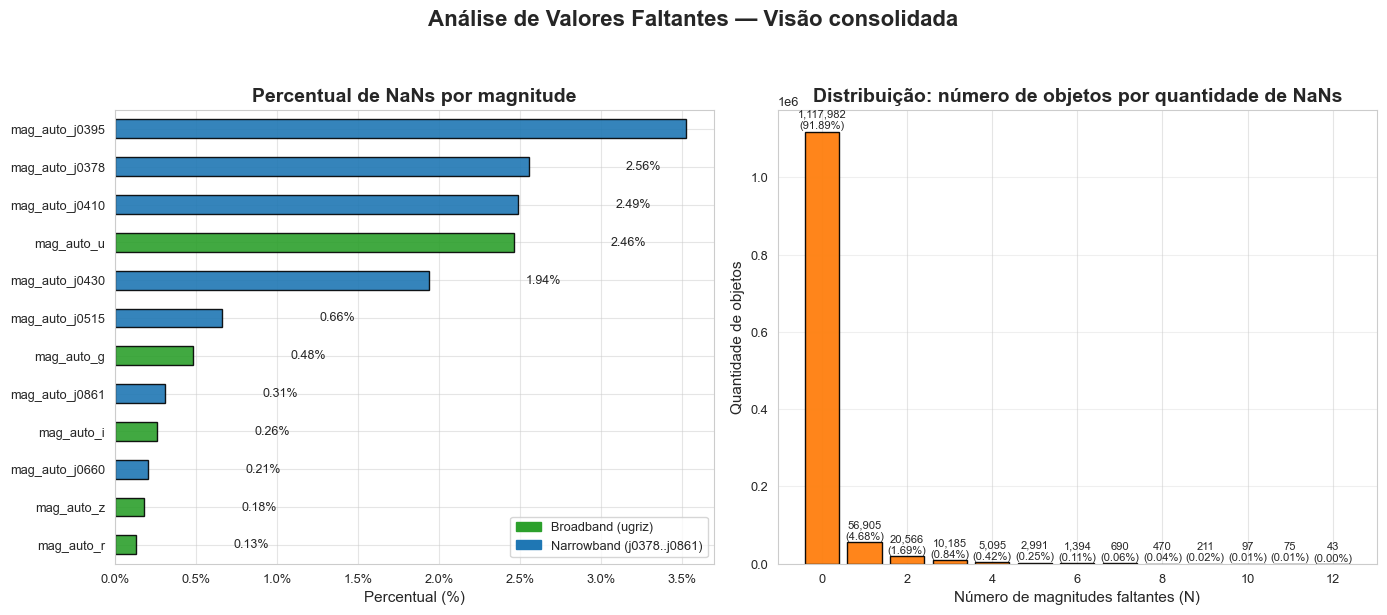

In [ ]:
from matplotlib.patches import Patch

# Layout reduzido: apenas 2 plots (percentual por magnitude | distribuição de N NaNs por objeto)
sns.set_style('whitegrid')
broad_color = '#2ca02c'   # verde (broad)
narrow_color = '#1f77b4'  # azul (narrow)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})

# --- Esquerda: Percentual de NaNs por magnitude (ordenado) ---
ax = axes[0]
nan_percentages = (df[mags_auto].isna().sum() / len(df) * 100).loc[nan_counts.index]
nan_percentages = nan_percentages.sort_values(ascending=True)
colors = [narrow_color if 'mag_auto_j' in mag else broad_color for mag in nan_percentages.index]
nan_percentages.plot(kind='barh', ax=ax, color=colors, edgecolor='k', alpha=0.9)

ax.set_title('Percentual de NaNs por magnitude', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentual (%)', fontsize=11)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.1f}%")  # formatação simples

# Anotações com porcentagem na barra
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.2f}%", (width + 0.6, p.get_y() + p.get_height() / 2),
                va='center', fontsize=9)

# Legenda customizada
ax.legend(handles=[Patch(color=broad_color, label='Broadband (ugriz)'),
                   Patch(color=narrow_color, label='Narrowband (j0378..j0861)')],
          loc='lower right', frameon=True)

# --- Direita: Distribuição de quantos objetos têm N NaNs (counts + %) ---
ax2 = axes[1]
distribution_sorted = distribution.sort_index()
x = distribution_sorted.index.astype(int)
y = distribution_sorted.values
bars = ax2.bar(x, y, color='#ff7f0e', edgecolor='k', alpha=0.95)

ax2.set_title('Distribuição: número de objetos por quantidade de NaNs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Número de magnitudes faltantes (N)', fontsize=11)
ax2.set_ylabel('Quantidade de objetos', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Anotar contagem e percentual acima das barras
total = len(df)
for i, (xi, yi) in enumerate(zip(x, y)):
    pct = yi / total * 100
    ax2.text(xi, yi + total * 0.0015, f"{yi:,}\n({pct:.2f}%)", ha='center', va='bottom', fontsize=8)

# Melhor ajuste de layout
plt.suptitle('Análise de Valores Faltantes — Visão consolidada', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Observando os gráficos acima, é perceptível que a variável (ou feature) mag_auto_j0395 apresenta o maior percentual de dados faltantes no conjunto. Outra análise pertinente é verificar se a própria ausência desses dados possui correlação entre as diferentes features. Por meio da matriz de correlação abaixo, é possível verificar que a ocorrência de dados faltantes não apresenta forte correlação entre as variáveis, o que sugere um padrão de aleatoriedade.

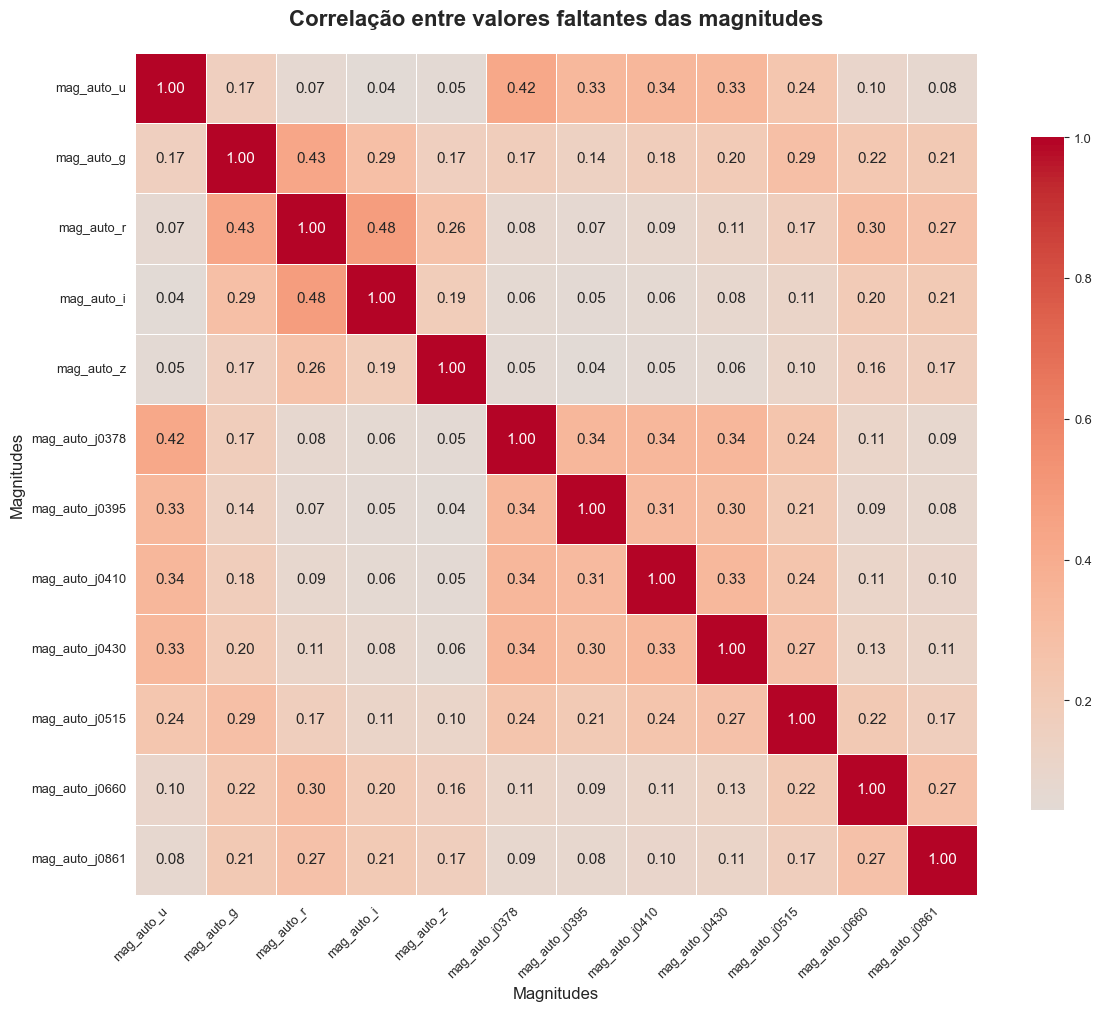

In [ ]:
# Heatmap de correlação de NaNs entre magnitudes
nan_matrix = df[mags_auto].isna().astype(int)
nan_corr = nan_matrix.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(nan_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlação entre valores faltantes das magnitudes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Magnitudes', fontsize=12)
plt.ylabel('Magnitudes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# plt.tight_layout()
plt.show()

Para tratar os dados faltantes do sistema, será utilizada a técnica de Imputação Multivariada por Equações Encadeadas (MICE). Esta técnica consiste na substituição de valores ausentes por meio de um método iterativo de aprendizado de máquina. O diferencial do MICE é que ele modela cada variável com dados faltantes usando as demais variáveis do dataset como preditoras. Esse processo de imputação e treinamento é repetido em ciclos (neste caso, 10 iterações), permitindo que os valores imputados convirjam e preservem a estrutura e as correlações naturais dos dados.


In [ ]:
# Imputação com MICE e salvar dataset
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("Imputando valores faltantes com MICE...")
print(f"NaNs antes: {df[mags_auto].isna().sum().sum()}")

# MICE usando as próprias 12 magnitudes
mice_imputer = IterativeImputer(max_iter=10, random_state=SEED, verbose=0)
df_imputed = df.copy()
df_imputed[mags_auto] = mice_imputer.fit_transform(df[mags_auto])

print(f"NaNs depois: {df_imputed[mags_auto].isna().sum().sum()}")

# Salvar dataset imputado
output_path = "../data/photoz_main_mice.parquet"
df_imputed.to_parquet(output_path, engine='pyarrow', index=False)
print(f"\n✓ Dataset imputado salvo em: {output_path}")
print(f"  Shape: {df_imputed.shape}")

Imputando valores faltantes com MICE...
NaNs antes: 185091


c:\Users\Carlos\Desktop\atividade_2\ML_project_ifusp\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


NaNs depois: 0

✓ Dataset imputado salvo em: ../data/photoz_main_mice.parquet
  Shape: (1216704, 29)


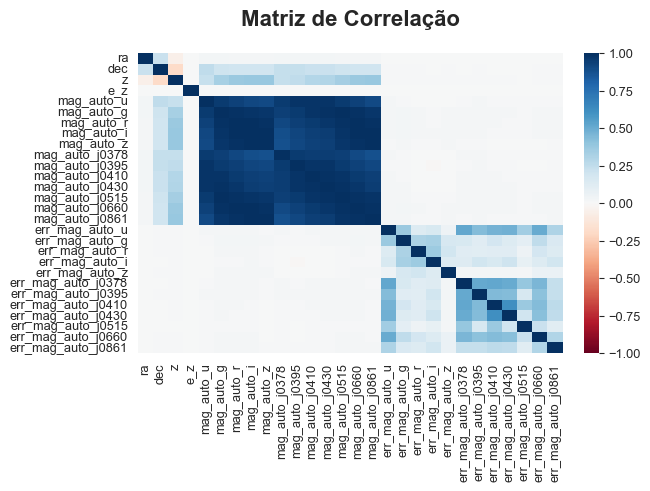

In [ ]:
df_cor = pd.read_parquet("../data/photoz_main_mice.parquet", engine='pyarrow')
df_cor = df_cor.drop(columns=['id'])
matriz_corr = df_cor.corr().round(2)
sns.heatmap(matriz_corr, cmap = 'RdBu', vmin=-1, vmax=1)
plt.title('Matriz de Correlação', fontsize=16, fontweight='bold', pad=20)
plt.show();

# Treinamento #

Antes do processo de treinamento, será feita mais uma filtragem nos dados, restringindo o conjunto de redshifts (z) utilizado ao intervalo [0,002, 3]. Além disso, os nomes das features do dataset serão renomeados e adicionadas novas features que representam a diferença entre as colunas de magnitude (i.e., as 'cores' fotométricas).

In [ ]:
# Carregar dataset e preparar X, y
path_train_main_mice = "./data/photoz_main_mice.parquet"
train_main_mice = pd.read_parquet(path_train_main_mice, engine='pyarrow')

print(f"Tamanho original dos dados: {train_main_mice.shape}")
train_main_mice = train_main_mice.query("z >= 0.002 and z <= 3")
print(f"Tamanho após filtro de redshift: {train_main_mice.shape}")

df_with_colors = train_main_mice.copy()

# Mapeamento de nomes para as colunas reais
mag_map = {
    'U': 'mag_auto_u',
    'G': 'mag_auto_g',
    'R': 'mag_auto_r',
    'I': 'mag_auto_i',
    'Z': 'mag_auto_z',
    'F378': 'mag_auto_j0378',
    'F395': 'mag_auto_j0395',
    'F410': 'mag_auto_j0410',
    'F430': 'mag_auto_j0430',
    'F515': 'mag_auto_j0515',
    'F660': 'mag_auto_j0660',
    'F861': 'mag_auto_j0861'
}

# Lista de cores desejadas
color_names = [
    "U-F378", "U-F395", "U-F410", "U-F430", "U-G", "U-F515", "U-R", "U-F660", "U-I", "U-F861", "U-Z",
    "F378-F395", "F378-F410", "F378-F430", "F378-G", "F378-F515", "F378-R", "F378-F660", "F378-I", "F378-F861", "F378-Z",
    "F395-F410", "F395-F430", "F395-G", "F395-F515", "F395-R", "F395-F660", "F395-I", "F395-F861", "F395-Z",
    "F410-F430", "F410-G", "F410-F515", "F410-R", "F410-F660", "F410-I", "F410-F861", "F410-Z",
    "F430-G", "F430-F515", "F430-R", "F430-F660", "F430-I", "F430-F861", "F430-Z",
    "G-F515", "G-R", "G-F660", "G-I", "G-F861", "G-Z",
    "F515-R", "F515-F660", "F515-I", "F515-F861", "F515-Z",
    "R-F660", "R-I", "R-F861", "R-Z",
    "F660-I", "F660-F861", "F660-Z",
    "I-F861", "I-Z",
    "F861-Z"
]

for color_name in color_names:
    # Separar os dois filtros (ex: "U-F378" -> "U" e "F378")
    mag1_name, mag2_name = color_name.split('-')
    
    # Pegar as colunas reais
    mag1_col = mag_map[mag1_name]
    mag2_col = mag_map[mag2_name]
    
    # Criar a cor (diferença entre magnitudes)
    df_with_colors[color_name] = df_with_colors[mag1_col] - df_with_colors[mag2_col]


X = df_with_colors[mags_auto+color_names].values
y = df_with_colors['z'].values

print(f"Dataset carregado: {train_main_mice.shape}")
print(f"Verificar NaNs: {train_main_mice[mags_auto].isna().sum().sum()}")
print(f"\nX shape: {X.shape}, y shape: {y.shape}")
print(f"Redshift - Min: {y.min():.4f}, Max: {y.max():.4f}, Média: {y.mean():.4f}")


Tamanho original dos dados: (1216704, 29)
Tamanho após filtro de redshift: (499415, 29)
Dataset carregado: (499415, 29)
Verificar NaNs: 0

X shape: (499415, 78), y shape: (499415,)
Redshift - Min: 0.0020, Max: 2.9999, Média: 0.4108
Dataset carregado: (499415, 29)
Verificar NaNs: 0

X shape: (499415, 78), y shape: (499415,)
Redshift - Min: 0.0020, Max: 2.9999, Média: 0.4108


Após a filtragem, renomeação e adição das features, o conjunto será dividido em treino e teste. Na sequência, será aplicado o reescalonamento MinMaxScaler. Para evitar o vazamento de dados (data leakage), o scaler será ajustado (fit) somente no conjunto de treino e, então, utilizado para transformar ambos os conjuntos (treino e teste).

In [17]:
# Divisão treino/teste com estratificação

# Criar bins de redshift para estratificação
n_bins = 2000  # número de faixas
z_bins = pd.cut(y, bins=n_bins, labels=False)

# Train/test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=z_bins  # Estratificar pelos bins
)

# Normalização
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 60)
print(f"Divisão estratificada: {len(X_train):,} treino - {len(X_test):,} teste")
print(f"({len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%)")

# Verificar distribuição dos bins
print(f"\nDistribuição de redshift nos conjuntos:")
print(f"Treino - Min: {y_train.min():.4f}, Max: {y_train.max():.4f}, Média: {y_train.mean():.4f}")
print(f"Teste  - Min: {y_test.min():.4f}, Max: {y_test.max():.4f}, Média: {y_test.mean():.4f}")

# Salvar scaler
scaler_path = "./data/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"\nScaler salvo: {scaler_path}")
print("=" * 60)

Divisão estratificada: 399,532 treino - 99,883 teste
(80.0% / 20.0%)

Distribuição de redshift nos conjuntos:
Treino - Min: 0.0020, Max: 2.9999, Média: 0.4108
Teste  - Min: 0.0020, Max: 2.9994, Média: 0.4108

Scaler salvo: ./data/scaler.pkl


Para o treinamento, será utilizado o modelo Random Forest. Visando sua otimização, será empregado o Optuna para procurar o conjunto de hiperparâmetros que maximize a performance do modelo.

O Optuna consiste em um framework de otimização para modelos de ML, no qual é feita uma busca inteligente pela melhor combinação de hiperparâmetros. Esta busca utiliza um algoritmo de otimização Bayesiana chamado Tree-structured Parzen Estimator (TPE). Este método permite ao Optuna decidir entre a exploração (testar novas regiões do espaço de hiperparâmetros) e a explotação (refinar a busca em regiões que já se mostraram promissoras), guiando suas decisões pela maximização da função objetivo (neste caso, a acurácia).

In [12]:
# Otimização de Hiperparâmetros com Optuna
print("=" * 60)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS COM OPTUNA - RANDOM FOREST")
print("=" * 60)

# Função objetivo para o Optuna
def objective(trial):
    # Sugerir hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': SEED,
        'n_jobs': 30  # Leve para não travar o PC
    }
    
    # Criar modelo com os hiperparâmetros sugeridos
    rf = RandomForestRegressor(**params)
    
    # Cross-validation com 3 folds
    scores = cross_val_score(rf, X_train_scaled, y_train, 
                              cv=3, scoring='neg_mean_squared_error', n_jobs=15)
    
    # Retornar a média do MSE (quanto menor, melhor)
    return scores.mean()

# Criar estudo Optuna com TPESampler (Bayesiano)
print("\nIniciando busca de hiperparâmetros com Optuna (TPE Sampler - Bayesiano)...")
print(f"  - Algoritmo: Tree-structured Parzen Estimator (TPE)")
print(f"  - Trials: 30 tentativas")
print(f"  - Warm-up: 10 trials aleatórios antes do TPE")
print("\nIsso pode demorar alguns minutos...")
print("=" * 60)

# Criar estudo com TPESampler otimizado
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=10,  # 10 trials aleatórios iniciais para exploração
        n_ei_candidates=24,   # Número de candidatos para Expected Improvement
        seed=SEED
    )
)

# Otimizar com mais trials para o TPE aprender melhor
study.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2025-10-23 15:26:22,887] A new study created in memory with name: no-name-70ba7cb0-f511-4b19-adad-582d3becc128


OTIMIZAÇÃO DE HIPERPARÂMETROS COM OPTUNA - RANDOM FOREST

Iniciando busca de hiperparâmetros com Optuna (TPE Sampler - Bayesiano)...
  - Algoritmo: Tree-structured Parzen Estimator (TPE)
  - Trials: 30 tentativas
  - Warm-up: 10 trials aleatórios antes do TPE

Isso pode demorar alguns minutos...


Best trial: 0. Best value: -0.123022:   7%|▋         | 1/15 [05:08<1:11:53, 308.13s/it]

[I 2025-10-23 15:31:31,013] Trial 0 finished with value: -0.12302168140512963 and parameters: {'n_estimators': 317, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  13%|█▎        | 2/15 [06:06<34:55, 161.21s/it]  

[I 2025-10-23 15:32:29,386] Trial 1 finished with value: -0.1261567174020724 and parameters: {'n_estimators': 141, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  20%|██        | 3/15 [08:07<28:35, 142.99s/it]

[I 2025-10-23 15:34:30,684] Trial 2 finished with value: -0.1244201062751562 and parameters: {'n_estimators': 195, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  27%|██▋       | 4/15 [16:24<51:46, 282.45s/it]

[I 2025-10-23 15:42:46,922] Trial 3 finished with value: -0.12304529373230501 and parameters: {'n_estimators': 484, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  33%|███▎      | 5/15 [17:22<33:37, 201.76s/it]

[I 2025-10-23 15:43:45,620] Trial 4 finished with value: -0.12421525581545413 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  40%|████      | 6/15 [19:07<25:18, 168.73s/it]

[I 2025-10-23 15:45:30,241] Trial 5 finished with value: -0.12582581343988 and parameters: {'n_estimators': 198, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  47%|████▋     | 7/15 [20:16<18:10, 136.29s/it]

[I 2025-10-23 15:46:39,728] Trial 6 finished with value: -0.12380292505248991 and parameters: {'n_estimators': 101, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 0. Best value: -0.123022:  53%|█████▎    | 8/15 [26:25<24:31, 210.22s/it]

[I 2025-10-23 15:52:48,266] Trial 7 finished with value: -0.12369788273916937 and parameters: {'n_estimators': 469, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: -0.12302168140512963.


Best trial: 8. Best value: -0.122778:  60%|██████    | 9/15 [30:05<21:19, 213.28s/it]

[I 2025-10-23 15:56:28,250] Trial 8 finished with value: -0.12277814591772457 and parameters: {'n_estimators': 307, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 8 with value: -0.12277814591772457.


Best trial: 8. Best value: -0.122778:  67%|██████▋   | 10/15 [32:12<15:33, 186.69s/it]

[I 2025-10-23 15:58:35,422] Trial 9 finished with value: -0.12328784913646161 and parameters: {'n_estimators': 177, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 8 with value: -0.12277814591772457.


Best trial: 8. Best value: -0.122778:  73%|███████▎  | 11/15 [36:15<13:35, 203.79s/it]

[I 2025-10-23 16:02:37,964] Trial 10 finished with value: -0.1237863644500522 and parameters: {'n_estimators': 332, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 8 with value: -0.12277814591772457.


Best trial: 11. Best value: -0.122743:  80%|████████  | 12/15 [41:03<11:29, 229.67s/it]

[I 2025-10-23 16:07:26,826] Trial 11 finished with value: -0.12274314295896399 and parameters: {'n_estimators': 316, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 11 with value: -0.12274314295896399.


Best trial: 12. Best value: -0.122655:  87%|████████▋ | 13/15 [47:08<09:00, 270.45s/it]

[I 2025-10-23 16:13:31,104] Trial 12 finished with value: -0.12265549690197748 and parameters: {'n_estimators': 389, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: -0.12265549690197748.


Best trial: 12. Best value: -0.122655:  93%|█████████▎| 14/15 [52:49<04:51, 291.74s/it]

[I 2025-10-23 16:19:12,063] Trial 13 finished with value: -0.12266585391773716 and parameters: {'n_estimators': 401, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: -0.12265549690197748.


Best trial: 12. Best value: -0.122655: 100%|██████████| 15/15 [58:07<00:00, 232.53s/it]

[I 2025-10-23 16:24:30,773] Trial 14 finished with value: -0.12274977175577922 and parameters: {'n_estimators': 393, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: -0.12265549690197748.


In [63]:
# Resultados da otimização e treinar melhor modelo
print("\n" + "=" * 60)
print("RESULTADOS DA OTIMIZAÇÃO")
print("=" * 60)

# Melhores hiperparâmetros encontrados
best_params = study.best_params
print(f"\nMelhores hiperparâmetros encontrados:")
for param, value in best_params.items():
    print(f"  - {param}: {value}")

print(f"\nMelhor score (CV): {-study.best_value:.6f} (MSE)")
print(f"RMSE (CV): {np.sqrt(-study.best_value):.6f}")

# Treinar modelo final com os melhores hiperparâmetros
best_params['random_state'] = SEED
best_params['n_jobs'] = 35  # Manter leve
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train_scaled, y_train)
# best_rf = RandomForestRegressor(n_estimators=389, max_depth=32, min_samples_split=4, min_samples_leaf=3, max_features='sqrt', n_jobs=30)

# Salvar o melhor modelo
model_path = "./data/best_rf_model.pkl"
joblib.dump(best_rf, model_path)
print(f"\n✓ Melhor modelo treinado e salvo em: {model_path}")
print("=" * 60)


RESULTADOS DA OTIMIZAÇÃO

Melhores hiperparâmetros encontrados:
  - n_estimators: 389
  - max_depth: 32
  - min_samples_split: 4
  - min_samples_leaf: 3
  - max_features: sqrt

Melhor score (CV): 0.122655 (MSE)
RMSE (CV): 0.350222

✓ Melhor modelo treinado e salvo em: ./data/best_rf_model.pkl

✓ Melhor modelo treinado e salvo em: ./data/best_rf_model.pkl


# Avaliar o modelo

In [4]:
# Carregar modelo, scaler e dados de teste
print("=" * 60)
print("CARREGANDO MODELO E DADOS PARA AVALIAÇÃO")
print("=" * 60)

# Carregar dataset completo
path_train_main_mice = "./data/photoz_main_mice.parquet"
train_main_mice = pd.read_parquet(path_train_main_mice, engine='pyarrow')

# Filtro de redshift
train_main_mice = train_main_mice.query("z >= 0.002 and z <= 3")

# Criar features (magnitudes + cores)
df_with_colors = train_main_mice.copy()

mag_map = {
    'U': 'mag_auto_u', 'G': 'mag_auto_g', 'R': 'mag_auto_r', 'I': 'mag_auto_i', 'Z': 'mag_auto_z',
    'F378': 'mag_auto_j0378', 'F395': 'mag_auto_j0395', 'F410': 'mag_auto_j0410', 'F430': 'mag_auto_j0430',
    'F515': 'mag_auto_j0515', 'F660': 'mag_auto_j0660', 'F861': 'mag_auto_j0861'
}

color_names = [
    "U-F378", "U-F395", "U-F410", "U-F430", "U-G", "U-F515", "U-R", "U-F660", "U-I", "U-F861", "U-Z",
    "F378-F395", "F378-F410", "F378-F430", "F378-G", "F378-F515", "F378-R", "F378-F660", "F378-I", "F378-F861", "F378-Z",
    "F395-F410", "F395-F430", "F395-G", "F395-F515", "F395-R", "F395-F660", "F395-I", "F395-F861", "F395-Z",
    "F410-F430", "F410-G", "F410-F515", "F410-R", "F410-F660", "F410-I", "F410-F861", "F410-Z",
    "F430-G", "F430-F515", "F430-R", "F430-F660", "F430-I", "F430-F861", "F430-Z",
    "G-F515", "G-R", "G-F660", "G-I", "G-F861", "G-Z",
    "F515-R", "F515-F660", "F515-I", "F515-F861", "F515-Z",
    "R-F660", "R-I", "R-F861", "R-Z",
    "F660-I", "F660-F861", "F660-Z",
    "I-F861", "I-Z", "F861-Z"
]

for color_name in color_names:
    mag1_name, mag2_name = color_name.split('-')
    mag1_col, mag2_col = mag_map[mag1_name], mag_map[mag2_name]
    df_with_colors[color_name] = df_with_colors[mag1_col] - df_with_colors[mag2_col]

X = df_with_colors[mags_auto + color_names].values
y = df_with_colors['z'].values

# Divisão treino/teste (mesma estratificação do treinamento)
n_bins = 2000
z_bins = pd.cut(y, bins=n_bins, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=z_bins)

# Carregar scaler e modelo
scaler = joblib.load("./data/scaler.pkl")
best_rf = joblib.load("./data/best_rf_model.pkl")

# Normalizar dados de teste
X_test_scaled = scaler.transform(X_test)

print(f"✓ Modelo carregado: {best_rf.__class__.__name__}")
print(f"✓ Scaler carregado: {scaler.__class__.__name__}")
print(f"✓ Dados de teste: {X_test.shape[0]:,} amostras, {X_test.shape[1]} features")
print("=" * 60)

CARREGANDO MODELO E DADOS PARA AVALIAÇÃO
✓ Modelo carregado: RandomForestRegressor
✓ Scaler carregado: MinMaxScaler
✓ Dados de teste: 99,883 amostras, 78 features
✓ Modelo carregado: RandomForestRegressor
✓ Scaler carregado: MinMaxScaler
✓ Dados de teste: 99,883 amostras, 78 features


In [5]:
# Fazer previsões no conjunto de teste
y_pred = best_rf.predict(X_test_scaled)

print("=" * 60)
print("PREVISÕES NO CONJUNTO DE TESTE")
print("=" * 60)
print(f"Previsões realizadas: {len(y_pred)}")
print(f"\nRedshift previsto (z_pred):")
print(f"  - Min: {y_pred.min():.4f}")
print(f"  - Max: {y_pred.max():.4f}")
print(f"  - Média: {y_pred.mean():.4f}")
print(f"  - Std: {y_pred.std():.4f}")
print("=" * 60)

PREVISÕES NO CONJUNTO DE TESTE
Previsões realizadas: 99883

Redshift previsto (z_pred):
  - Min: 0.0094
  - Max: 2.5230
  - Média: 0.4149
  - Std: 0.4808


In [6]:
# Métricas de avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calcular bias
bias = np.mean(y_pred - y_test)

# Calcular scatter (desvio normalizado)
dz = (y_pred - y_test) / (1 + y_test)
nmad = 1.4826 * np.median(np.abs(dz - np.median(dz)))  # Normalized Median Absolute Deviation

print("=" * 60)
print("MÉTRICAS DE AVALIAÇÃO")
print("=" * 60)
print(f"\nMétricas gerais:")
print(f"  - MSE:  {mse:.6f}")
print(f"  - RMSE: {rmse:.6f}")
print(f"  - MAE:  {mae:.6f}")
print(f"  - R²:   {r2:.6f}")

print(f"\nMétricas específicas para Photo-z:")
print(f"  - Bias: {bias:.6f}")
print(f"  - NMAD (σ): {nmad:.6f}")

# Porcentagem de outliers (|Δz/(1+z)| > 0.15)
outlier_threshold = 0.15
outliers = np.abs(dz) > outlier_threshold
outlier_rate = (outliers.sum() / len(y_test)) * 100

print(f"\nOutliers (|Δz/(1+z)| > {outlier_threshold}):")
print(f"  - Quantidade: {outliers.sum()} / {len(y_test)}")
print(f"  - Taxa: {outlier_rate:.2f}%")
print("=" * 60)

MÉTRICAS DE AVALIAÇÃO

Métricas gerais:
  - MSE:  0.131198
  - RMSE: 0.362212
  - MAE:  0.173973
  - R²:   0.654917

Métricas específicas para Photo-z:
  - Bias: 0.004118
  - NMAD (σ): 0.054342

Outliers (|Δz/(1+z)| > 0.15):
  - Quantidade: 19955 / 99883
  - Taxa: 19.98%


A avaliação do desempenho do modelo será realizada por meio de um conjunto de métricas, divididas em métricas gerais de regressão e métricas específicas para a análise de *Photo-z*.

### Métricas Gerais

* **Mean Absolute Error (MAE):** Corresponde à média do módulo da diferença (erro absoluto) entre os valores reais e os previstos.
* **Mean Squared Error (MSE):** A média do quadrado dos erros. Esta métrica penaliza erros grandes de forma mais significativa que o MAE.
* **Root Mean Squared Error (RMSE):** A raiz quadrada do MSE. Expressa o erro médio na mesma unidade da variável-alvo (redshift), mas é mais sensível a outliers que o MAE.
* **Coeficiente de Determinação ($R^2$):** Mede a proporção da variância nos dados observados que é explicada pelo modelo. Um valor de 1 indica um ajuste perfeito, enquanto 0 indica que o modelo não é melhor que a média dos dados.

### Métricas Específicas para Photo-z

* **Bias:** Avalia a tendência sistemática (viés) do modelo, geralmente definida como o erro médio ($z_{previsto} - z_{real}$). Valores próximos de zero indicam um modelo imparcial, que não superestima ou subestima os valores de forma consistente.
* **Normalized Median Absolute Deviation (NMAD):** Um estimador robusto da dispersão (precisão) dos erros. Por ser baseado na mediana, não é significativamente afetado por outliers, fornecendo uma medida mais confiável da precisão do modelo para a maioria dos dados.

### Análise de Outliers

* Serão definidos como *outliers*  os pontos onde o erro normalizado for maior que 15%. Este erro é comumente calculado como:
    $$\frac{|z_{real} - z_{previsto}|}{(1 + z_{real})} > 0.15$$



MSE: 0.131198  RMSE: 0.362212  MAE: 0.173973  R²: 0.6549
Bias: 0.004118  NMAD: 0.054342  Outliers (>0.15): 19.98%


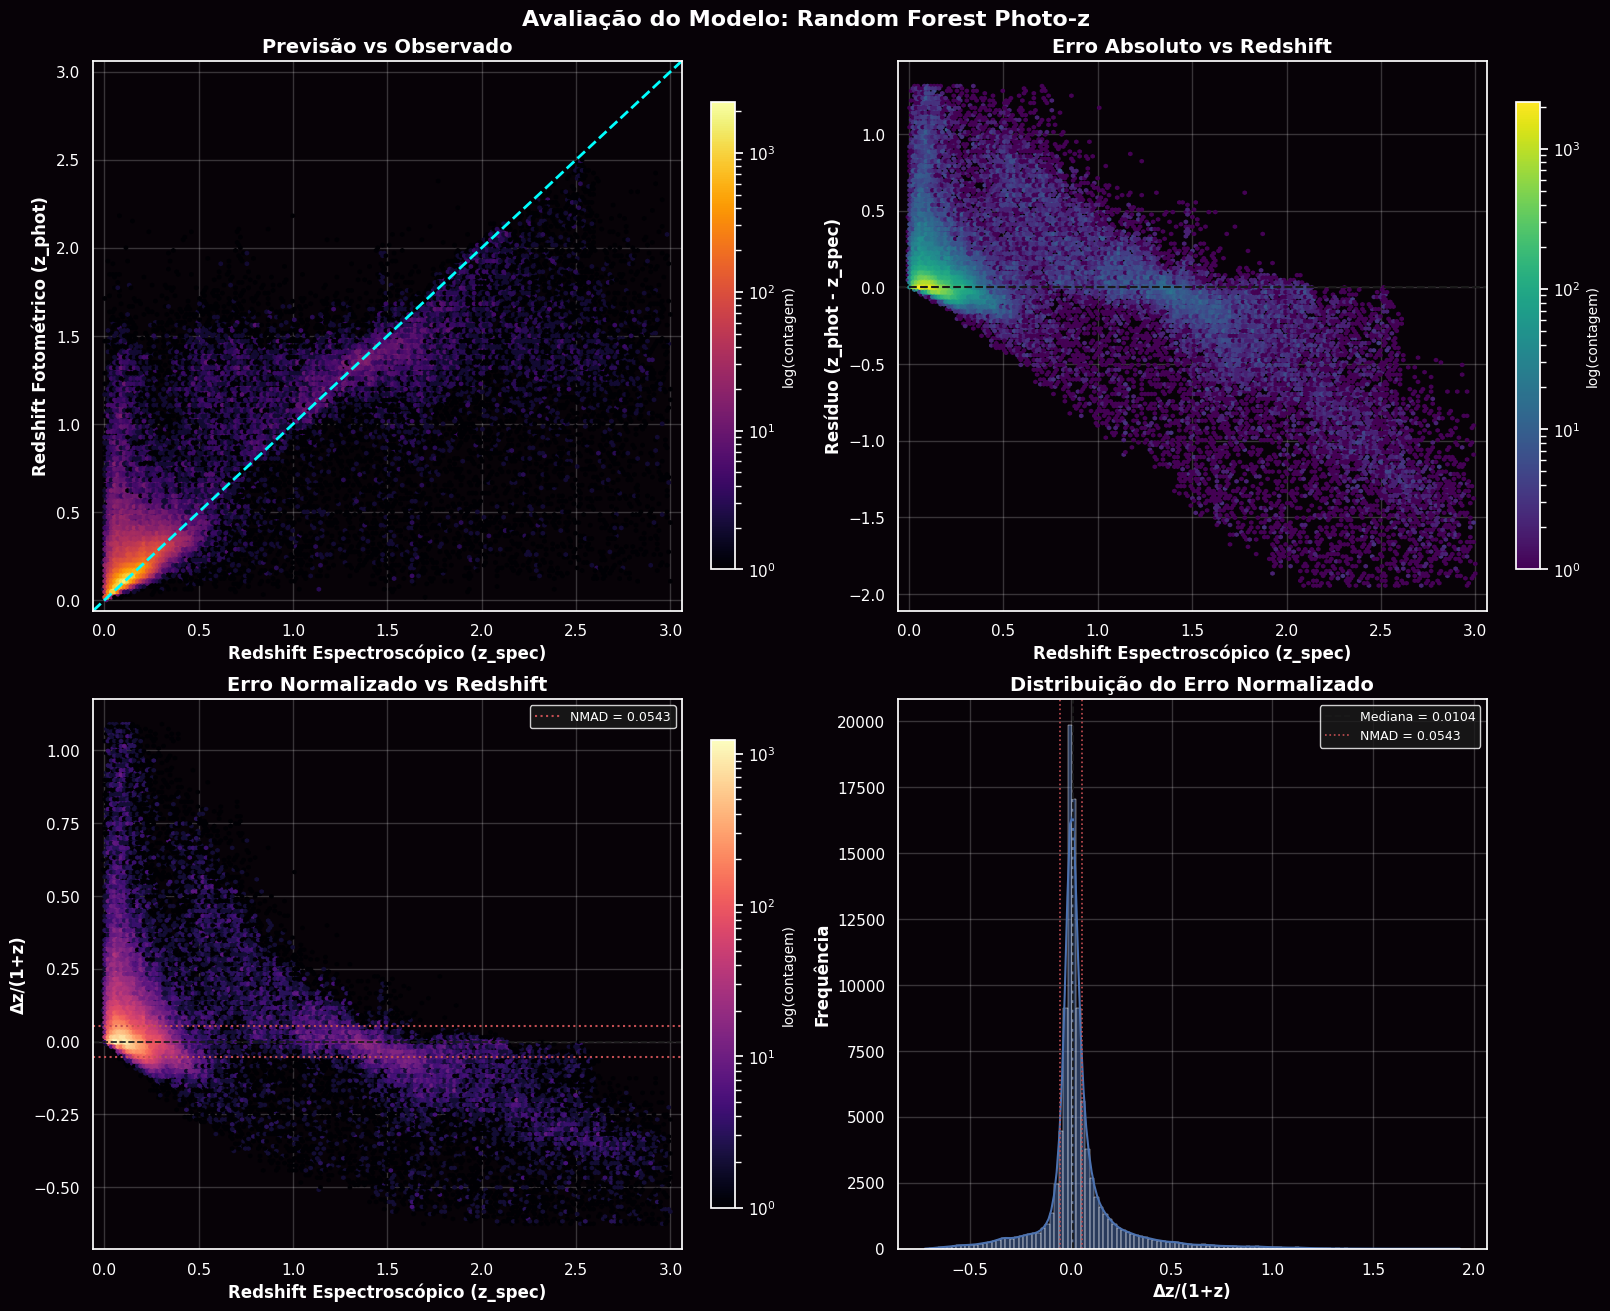

In [17]:
# Plots em 2x2 estilo consolidado (usar todo o z (y) no eixo x)
# Usa variáveis existentes: y_test, y_pred, mse, r2, nmad, outlier_rate, bias, rmse, mae, y

# (re)calcular métricas rápidas para garantir consistência
residuals = y_pred - y_test
dz = (y_pred - y_test) / (1 + y_test)
nmad_val = 1.4826 * np.median(np.abs(dz - np.median(dz)))
outlier_frac = (np.abs(dz) > 0.15).mean() * 100

print(f"MSE: {mse:.6f}  RMSE: {rmse:.6f}  MAE: {mae:.6f}  R²: {r2:.4f}")
print(f"Bias: {bias:.6f}  NMAD: {nmad_val:.6f}  Outliers (>0.15): {outlier_frac:.2f}%")

# Usar todo o intervalo de z disponível (variável `y`) como eixo x
x_min = np.nanmin(y)
x_max = np.nanmax(y)
if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
    x_min, x_max = 0.0, 0.5

# pequeno padding para melhor visual
pad = 0.02 * (x_max - x_min) if (x_max - x_min) > 0 else 0.01
x0, x1 = x_min - pad, x_max + pad

fig, axes = plt.subplots(2, 2, figsize=(16, 13))
cmap = 'inferno'

# 1) z_spec vs z_phot (hexbin) -- x usando todo o y
ax = axes[0, 0]
hb = ax.hexbin(y_test, y_pred, gridsize=180, bins='log', cmap=cmap, mincnt=1,
               extent=(x0, x1, x0, x1))
ax.plot([x0, x1], [x0, x1], ls='--', color='cyan', lw=2)
ax.set_xlim(x0, x1); ax.set_ylim(x0, x1)
ax.set_xlabel('Redshift Espectroscópico (z_spec)', fontsize=12, fontweight='bold')
ax.set_ylabel('Redshift Fotométrico (z_phot)', fontsize=12, fontweight='bold')
ax.set_title('Previsão vs Observado', fontsize=14, fontweight='bold')
cb = fig.colorbar(hb, ax=ax, shrink=0.85)
cb.set_label('log(contagem)', fontsize=10)

# 2) Resíduos vs z_spec (usar mesmo x-range)
ax = axes[0, 1]
# escolher limites de y para resíduos com base em percentis para evitar outliers extremos
res_low, res_high = np.nanpercentile(residuals, [0.5, 99.5])
res_pad = 0.05 * (res_high - res_low) if (res_high - res_low) > 0 else 0.01
hb2 = ax.hexbin(y_test, residuals, gridsize=180, bins='log', cmap='viridis', mincnt=1,
                extent=(x0, x1, res_low - res_pad, res_high + res_pad))
ax.axhline(0, color='k', ls='--', lw=1.5)
ax.set_xlim(x0, x1)
ax.set_xlabel('Redshift Espectroscópico (z_spec)', fontsize=12, fontweight='bold')
ax.set_ylabel('Resíduo (z_phot - z_spec)', fontsize=12, fontweight='bold')
ax.set_title('Erro Absoluto vs Redshift', fontsize=14, fontweight='bold')
cb2 = fig.colorbar(hb2, ax=ax, shrink=0.85)
cb2.set_label('log(contagem)', fontsize=10)

# 3) Δz/(1+z) vs z_spec (usar mesmo x-range)
ax = axes[1, 0]
dz_low, dz_high = np.nanpercentile(dz, [0.5, 99.5])
dz_pad = 0.05 * (dz_high - dz_low) if (dz_high - dz_low) > 0 else 0.01
hb3 = ax.hexbin(y_test, dz, gridsize=180, bins='log', cmap='magma', mincnt=1,
                extent=(x0, x1, dz_low - dz_pad, dz_high + dz_pad))
ax.axhline(0, color='k', ls='--', lw=1.2)
ax.set_xlim(x0, x1)
ax.set_xlabel('Redshift Espectroscópico (z_spec)', fontsize=12, fontweight='bold')
ax.set_ylabel('Δz/(1+z)', fontsize=12, fontweight='bold')
ax.set_title('Erro Normalizado vs Redshift', fontsize=14, fontweight='bold')
cb3 = fig.colorbar(hb3, ax=ax, shrink=0.85)
cb3.set_label('log(contagem)', fontsize=10)
# adicionar linhas de ±NMAD
ax.axhline(nmad_val, color='r', ls=':', lw=1.5, label=f'NMAD = {nmad_val:.4f}')
ax.axhline(-nmad_val, color='r', ls=':', lw=1.5)
ax.legend(loc='upper right', fontsize=9)

# 4) Histograma de Δz/(1+z)
ax = axes[1, 1]
sns.histplot(dz, bins=120, kde=True, stat='count', color='#4c72b0', ax=ax)
ax.set_xlabel('Δz/(1+z)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax.set_title('Distribuição do Erro Normalizado', fontsize=14, fontweight='bold')
ax.axvline(np.median(dz), color='k', ls='--', lw=1.3, label=f'Mediana = {np.median(dz):.4f}')
ax.axvline(nmad_val, color='r', ls=':', lw=1.2, label=f'NMAD = {nmad_val:.4f}')
ax.axvline(-nmad_val, color='r', ls=':', lw=1.2)
ax.legend(fontsize=9)

plt.suptitle('Avaliação do Modelo: Random Forest Photo-z', fontsize=16, fontweight='bold')

if dark_mode == True:
    plt.savefig("imagens/photoz_rf_evaluation_dark.png", dpi=300)
else:
    plt.savefig("imagens/photoz_rf_evaluation.png", dpi=300)
plt.show()

## Análises Adicionais de Photo-z

Análises complementares para entender melhor o comportamento do modelo.

ANÁLISE DE OUTLIERS POR FAIXA DE REDSHIFT

 Faixa z  N Objetos     NMAD      Bias  Outliers (%)
0.0-0.3      74227 0.040716  0.067402     12.543953
0.3-0.6       7477 0.110918  0.094245     28.380366
0.6-1.0       3775 0.196107  0.124960     57.668874
1.0-1.5       4900 0.076570 -0.027381     19.183673
1.5-3.0       9504 0.177446 -0.216667     56.870791


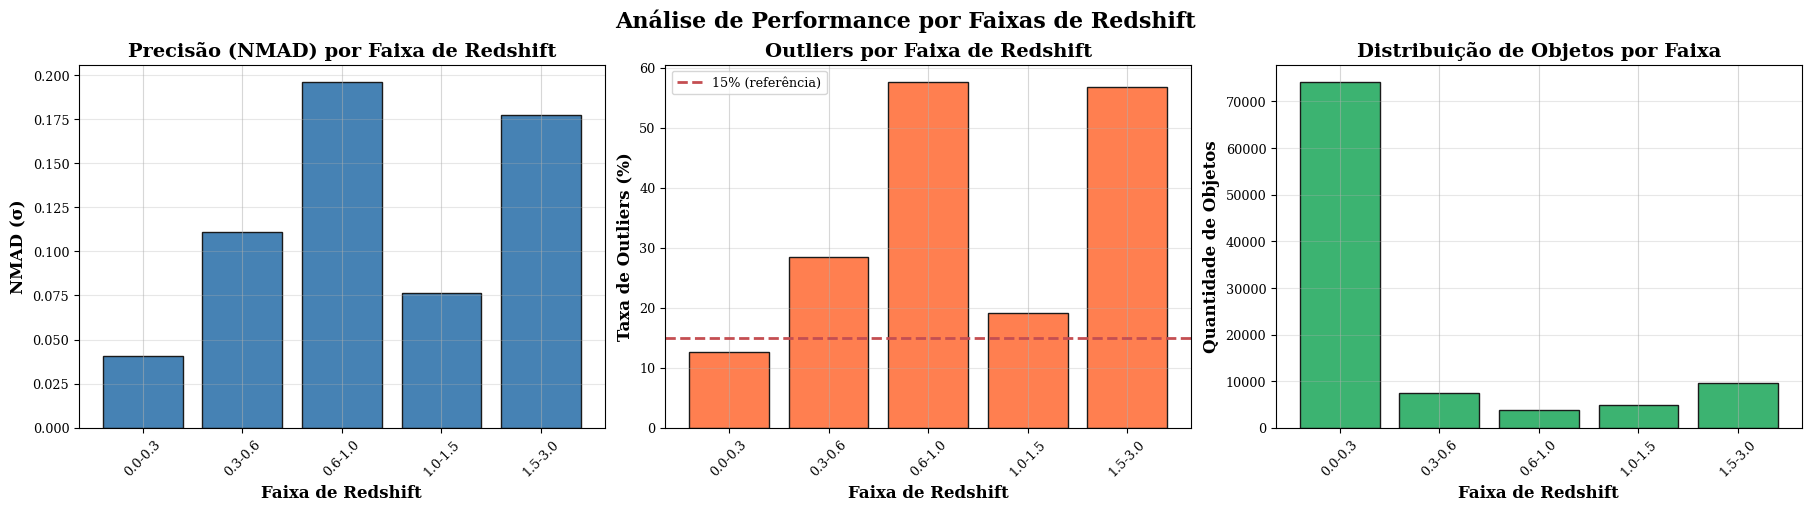

In [20]:
# 1. Análise de Outliers por Faixas de Redshift
print("=" * 60)
print("ANÁLISE DE OUTLIERS POR FAIXA DE REDSHIFT")
print("=" * 60)

# Definir faixas de redshift
z_ranges = [(0, 0.3), (0.3, 0.6), (0.6, 1.0), (1.0, 1.5), (1.5, 3.0)]
outlier_threshold = 0.15

results = []
for z_min, z_max in z_ranges:
    mask = (y_test >= z_min) & (y_test < z_max)
    n_objects = mask.sum()
    
    if n_objects > 0:
        dz_range = dz[mask]
        outliers_range = np.abs(dz_range) > outlier_threshold
        outlier_rate = (outliers_range.sum() / n_objects) * 100
        nmad_range = 1.4826 * np.median(np.abs(dz_range - np.median(dz_range)))
        bias_range = np.mean(dz_range)
        
        results.append({
            'Faixa z': f'{z_min:.1f}-{z_max:.1f}',
            'N Objetos': n_objects,
            'NMAD': nmad_range,
            'Bias': bias_range,
            'Outliers (%)': outlier_rate
        })

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))
print("=" * 60)

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: NMAD por faixa
ax = axes[0]
ax.bar(range(len(df_results)), df_results['NMAD'], color='steelblue', edgecolor='k')
ax.set_xlabel('Faixa de Redshift', fontsize=12, fontweight='bold')
ax.set_ylabel('NMAD (σ)', fontsize=12, fontweight='bold')
ax.set_title('Precisão (NMAD) por Faixa de Redshift', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(df_results)))
ax.set_xticklabels(df_results['Faixa z'], rotation=45)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Taxa de outliers
ax = axes[1]
ax.bar(range(len(df_results)), df_results['Outliers (%)'], color='coral', edgecolor='k')
ax.set_xlabel('Faixa de Redshift', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Outliers (%)', fontsize=12, fontweight='bold')
ax.set_title('Outliers por Faixa de Redshift', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(df_results)))
ax.set_xticklabels(df_results['Faixa z'], rotation=45)
ax.axhline(15, color='r', ls='--', lw=2, label='15% (referência)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Número de objetos
ax = axes[2]
ax.bar(range(len(df_results)), df_results['N Objetos'], color='mediumseagreen', edgecolor='k')
ax.set_xlabel('Faixa de Redshift', fontsize=12, fontweight='bold')
ax.set_ylabel('Quantidade de Objetos', fontsize=12, fontweight='bold')
ax.set_title('Distribuição de Objetos por Faixa', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(df_results)))
ax.set_xticklabels(df_results['Faixa z'], rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Análise de Performance por Faixas de Redshift', fontsize=16, fontweight='bold')
plt.show()

ANÁLISE DE OUTLIERS CATASTRÓFICOS
Outliers catastróficos: 19955 / 99883 (19.98%)


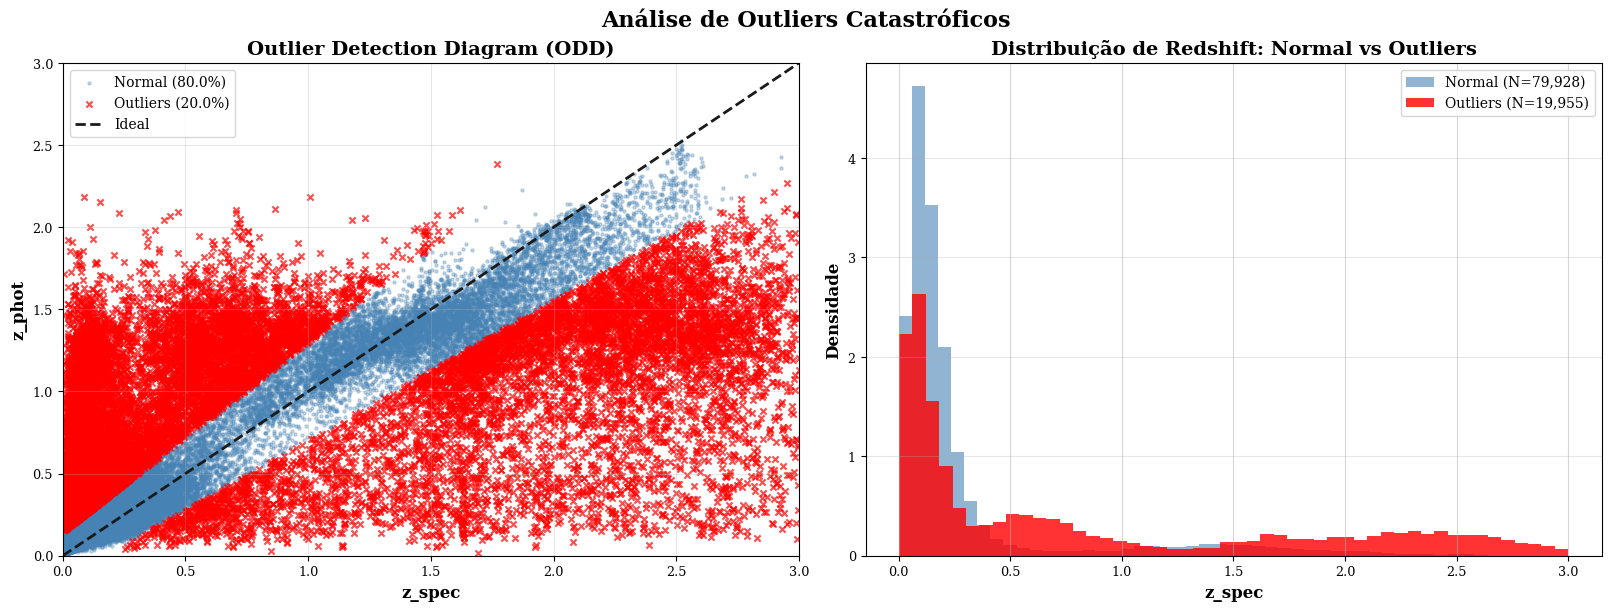


Estatísticas dos Outliers Catastróficos:
  z_spec médio: 0.8442
  z_spec mediano: 0.4118
  z_spec min-max: [0.0021, 2.9994]


In [21]:
# 2. Análise de Outliers Catastróficos (ODD - Outlier Detection Diagram)
print("=" * 60)
print("ANÁLISE DE OUTLIERS CATASTRÓFICOS")
print("=" * 60)

# Identificar outliers catastróficos (|Δz/(1+z)| > 0.15)
catastrophic_mask = np.abs(dz) > 0.15
n_catastrophic = catastrophic_mask.sum()
catastrophic_rate = (n_catastrophic / len(y_test)) * 100

print(f"Outliers catastróficos: {n_catastrophic} / {len(y_test)} ({catastrophic_rate:.2f}%)")

# Criar ODD (Outlier Detection Diagram)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ODD - z_phot vs z_spec colorido por outlier
ax = axes[0]
# Não-outliers em azul
ax.scatter(y_test[~catastrophic_mask], y_pred[~catastrophic_mask], 
           s=5, alpha=0.3, c='steelblue', label=f'Normal ({100-catastrophic_rate:.1f}%)')
# Outliers em vermelho
ax.scatter(y_test[catastrophic_mask], y_pred[catastrophic_mask], 
           s=20, alpha=0.7, c='red', marker='x', label=f'Outliers ({catastrophic_rate:.1f}%)')
ax.plot([0, 3], [0, 3], 'k--', lw=2, label='Ideal')
ax.set_xlabel('z_spec', fontsize=12, fontweight='bold')
ax.set_ylabel('z_phot', fontsize=12, fontweight='bold')
ax.set_title('Outlier Detection Diagram (ODD)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# Plot 2: Distribuição de z_spec para outliers vs não-outliers
ax = axes[1]
ax.hist(y_test[~catastrophic_mask], bins=50, alpha=0.6, color='steelblue', 
        label=f'Normal (N={len(y_test[~catastrophic_mask]):,})', density=True)
ax.hist(y_test[catastrophic_mask], bins=50, alpha=0.8, color='red', 
        label=f'Outliers (N={n_catastrophic:,})', density=True)
ax.set_xlabel('z_spec', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidade', fontsize=12, fontweight='bold')
ax.set_title('Distribuição de Redshift: Normal vs Outliers', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Análise de Outliers Catastróficos', fontsize=16, fontweight='bold')
plt.show()

# Análise estatística dos outliers
print(f"\nEstatísticas dos Outliers Catastróficos:")
print(f"  z_spec médio: {y_test[catastrophic_mask].mean():.4f}")
print(f"  z_spec mediano: {np.median(y_test[catastrophic_mask]):.4f}")
print(f"  z_spec min-max: [{y_test[catastrophic_mask].min():.4f}, {y_test[catastrophic_mask].max():.4f}]")

IMPORTÂNCIA DAS FEATURES

Top 20 features mais importantes:
       Feature  Importance
           U-I    0.070203
        U-F861    0.057134
        U-F660    0.053613
           U-R    0.049133
           G-I    0.046467
           U-Z    0.038833
        F378-I    0.036093
     F378-F861    0.032659
        F378-Z    0.028300
           G-Z    0.026885
     F378-F660    0.026455
           G-R    0.025228
        F378-R    0.023552
        G-F861    0.021922
    mag_auto_z    0.019918
        G-F660    0.019913
mag_auto_j0861    0.018510
        U-F515    0.018008
    mag_auto_i    0.017207
mag_auto_j0660    0.012707


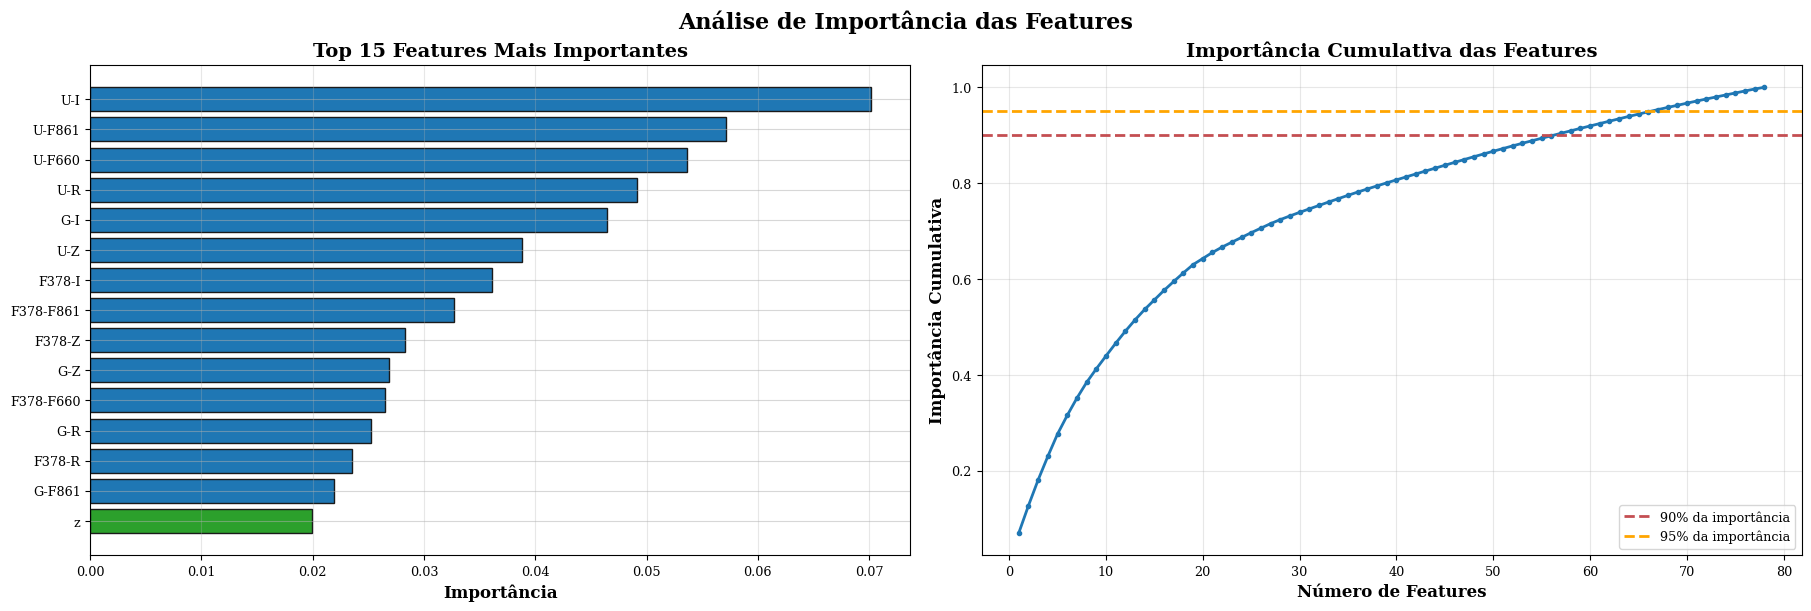


Número de features para:
  90% da importância: 57 features
  95% da importância: 67 features


In [22]:
# 3. Feature Importance - Quais features são mais importantes?
print("=" * 60)
print("IMPORTÂNCIA DAS FEATURES")
print("=" * 60)

# Obter importâncias
feature_names = mags_auto + color_names
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 features mais importantes:")
print(feature_importance_df.head(20).to_string(index=False))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top 15 features
ax = axes[0]
top_15 = feature_importance_df.head(15)
colors = ['#2ca02c' if 'mag_auto' in f and not 'j0' in f else '#1f77b4' for f in top_15['Feature']]
ax.barh(range(len(top_15)), top_15['Importance'], color=colors, edgecolor='k')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels([f.replace('mag_auto_', '') for f in top_15['Feature']])
ax.set_xlabel('Importância', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features Mais Importantes', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Plot 2: Importância cumulativa
ax = axes[1]
cumsum = np.cumsum(feature_importance_df['Importance'].values)
ax.plot(range(1, len(cumsum)+1), cumsum, marker='o', markersize=3, linewidth=2)
ax.axhline(0.9, color='r', ls='--', lw=2, label='90% da importância')
ax.axhline(0.95, color='orange', ls='--', lw=2, label='95% da importância')
ax.set_xlabel('Número de Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Importância Cumulativa', fontsize=12, fontweight='bold')
ax.set_title('Importância Cumulativa das Features', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Análise de Importância das Features', fontsize=16, fontweight='bold')
plt.show()

# Quantas features são necessárias para 90% e 95%
n_90 = np.argmax(cumsum >= 0.9) + 1
n_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\nNúmero de features para:")
print(f"  90% da importância: {n_90} features")
print(f"  95% da importância: {n_95} features")

MATRIZ DE CONFUSÃO - REDSHIFT BINNED


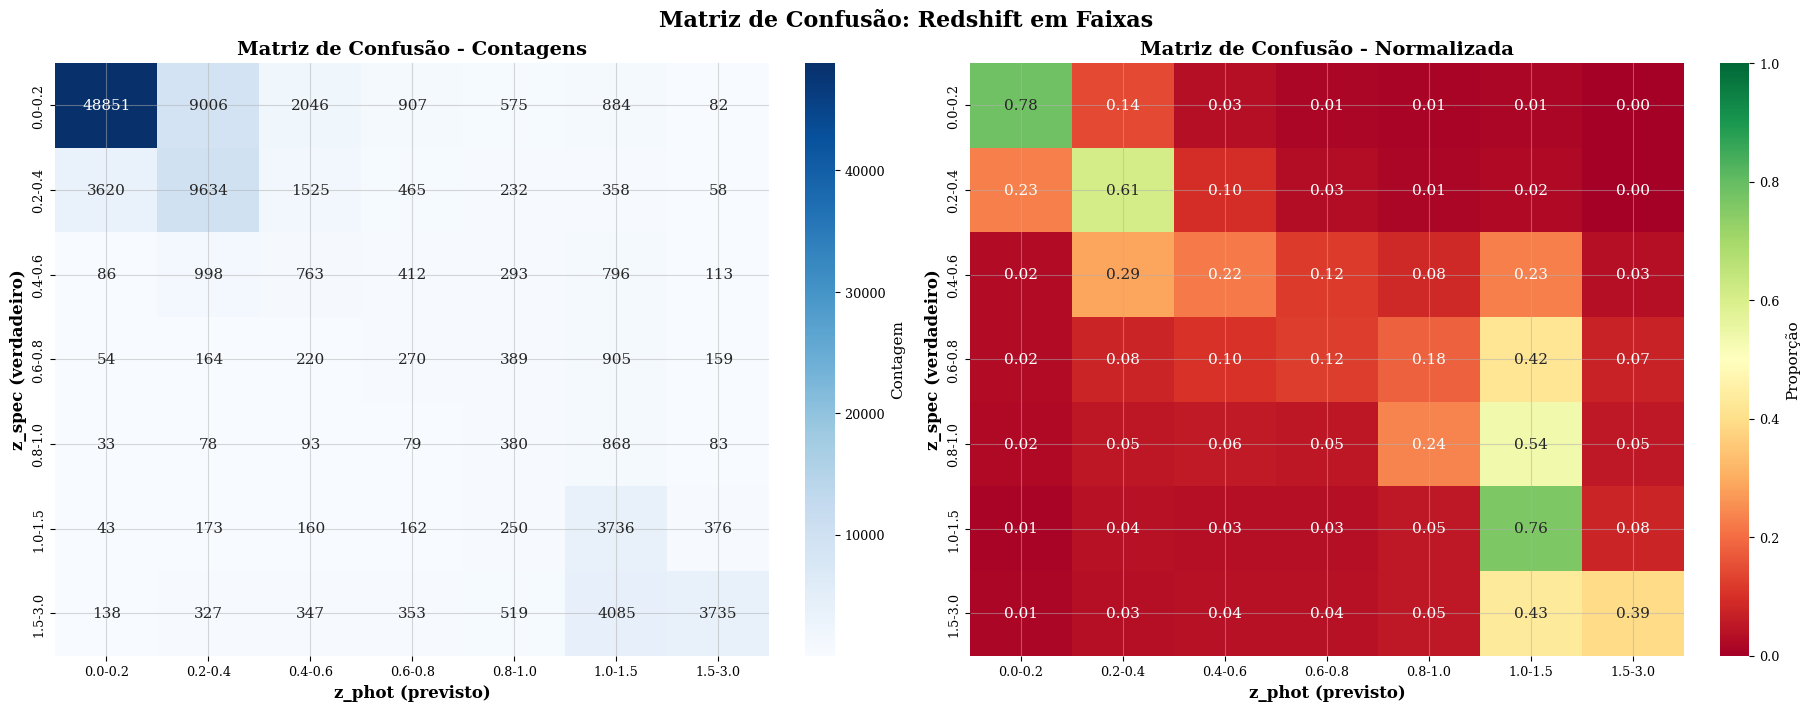


Acurácia por faixa de redshift:
  0.0-0.2: 78.3%
  0.2-0.4: 60.6%
  0.4-0.6: 22.0%
  0.6-0.8: 12.5%
  0.8-1.0: 23.5%
  1.0-1.5: 76.2%
  1.5-3.0: 39.3%


In [23]:
# 4. Matriz de Confusão de Redshift (Binned)
print("=" * 60)
print("MATRIZ DE CONFUSÃO - REDSHIFT BINNED")
print("=" * 60)

# Criar bins de redshift para matriz de confusão
z_bins_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 3.0]
z_bins_labels = ['0.0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0', '1.0-1.5', '1.5-3.0']

y_test_binned = pd.cut(y_test, bins=z_bins_edges, labels=z_bins_labels)
y_pred_binned = pd.cut(y_pred, bins=z_bins_edges, labels=z_bins_labels)

# Criar matriz de confusão
conf_matrix = confusion_matrix(y_test_binned, y_pred_binned, labels=z_bins_labels)

# Normalizar por linha (percentual por classe verdadeira)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Matriz absoluta
ax = axes[0]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=z_bins_labels, yticklabels=z_bins_labels, ax=ax, cbar_kws={'label': 'Contagem'})
ax.set_xlabel('z_phot (previsto)', fontsize=12, fontweight='bold')
ax.set_ylabel('z_spec (verdadeiro)', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - Contagens', fontsize=14, fontweight='bold')

# Matriz normalizada
ax = axes[1]
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=z_bins_labels, yticklabels=z_bins_labels, ax=ax, cbar_kws={'label': 'Proporção'})
ax.set_xlabel('z_phot (previsto)', fontsize=12, fontweight='bold')
ax.set_ylabel('z_spec (verdadeiro)', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - Normalizada', fontsize=14, fontweight='bold')

plt.suptitle('Matriz de Confusão: Redshift em Faixas', fontsize=16, fontweight='bold')
plt.show()

# Acurácia por faixa
print("\nAcurácia por faixa de redshift:")
for i, label in enumerate(z_bins_labels):
    accuracy = conf_matrix_norm[i, i]
    print(f"  {label}: {accuracy*100:.1f}%")